In [22]:
import numpy as np
import torch
import torch.nn as nn
import csv
import os
import cv2
from PIL import Image

In [23]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [24]:
data_path = r"../1-generate/data/"
n_epoch = 3000
match = 35
hidden_neurons = 200

model_path = ""
stop_train = 1e-5

In [25]:
'''
ACTIONS = {
    "noop": 0,
    "accelerate": 1,
    "right": 2,
    "left": 3,
    "break": 4,
    "right_break": 5,
    "left_break": 6,
    "right_accelerate": 7,
    "left_accelerate": 8,
}
'''

ACTIONS = {
    "right": 2,
    "left": 3,
}

ACTIONS_LIST = list(ACTIONS.values())

In [ ]:
ACTIONS_LIST

In [26]:
def load_npz(m):
    path = data_path + "match_" + str(m) + "/npz/"

    actions = np.load(path + 'actions.npz')
    lifes = np.load(path + 'lifes.npz')
    frames = np.load(path + 'frames.npz')
    rewards = np.load(path + 'rewards.npz')

    arr_actions = actions.f.arr_0
    arr_lifes = lifes.f.arr_0
    arr_frames = frames.f.arr_0
    arr_rewards = rewards.f.arr_0

    print("Successfully loaded NPZ.")

    return arr_actions.shape[0], arr_frames, arr_actions, arr_rewards, arr_lifes

In [27]:
num_of_frames, frames, actions, rewards, lifes = load_npz(match)

Successfully loaded NPZ.


In [28]:
def prepare_action_data(action):

    new_action = np.zeros((1, len(ACTIONS)), dtype=int) 

    new_action[0, ACTIONS_LIST.index(action)] = 1

    return new_action

In [29]:
action_one_hot = [prepare_action_data(i) for i in actions]
Y_train = np.array(action_one_hot)
Y_train = Y_train.reshape(1, len(Y_train), -1)

In [30]:
X_train = frames.reshape(1, len(frames) ,-1)

In [31]:
X_train = torch.tensor(X_train).float()
Y_train = torch.tensor(Y_train).float()

In [32]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.h0 = torch.zeros(self.n_layers, 1, self.hidden_dim).to(device)
        self.c0 = torch.zeros(self.n_layers, 1, self.hidden_dim).to(device)

        #Defining the layers
        # RNN Layer
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)  
        
        self.sigmoid1 = nn.Sigmoid()
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
        
        self.softmax = nn.Softmax()
    
    def forward(self, x):
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        # hidden = self.init_hidden(batch_size)
        self.h0 = torch.zeros(self.n_layers, 1, self.hidden_dim).to(device)
        self.c0 = torch.zeros(self.n_layers, 1, self.hidden_dim).to(device)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.lstm(x, (self.h0, self.c0))
        
        out = self.sigmoid1(out)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        out = self.softmax(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [33]:
model = Model(input_size=20400, output_size=2, hidden_dim=200, n_layers=1)

In [34]:
# We'll also set the model to the device that we defined earlier (default is CPU)
model.cuda()
X_train = X_train.cuda() 
Y_train = Y_train.cuda()

# Define hyperparameters
n_epochs = 5000
lr=0.01

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.Adadelta(model.parameters())

In [35]:
X_train.shape

torch.Size([1, 120, 20400])

In [36]:
loss_arr = []

In [ ]:
# Training Run

# model.train()

epoch = 1

while(True):
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    X_train.to(device)
    output, hidden = model(X_train)
    # print(output)
    loss = criterion(output, Y_train.view(-1,2).float())
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordinglyw
    
    if epoch%10 == 0:
        loss_arr.append(loss.item())
        acc = float((torch.sum((torch.argmax(output, axis=1) == torch.argmax(Y_train.squeeze(), axis=1)).int())/120))
        print('Epoch: {}/{}.............'.format(epoch, 5000), end=' ')
        print("Loss: {:.15f} Acc: {:.15f}".format(loss.item(), acc))
        
    epoch += 1

In [ ]:
import numpy as np
loss_arr = np.array(loss_arr)
np.savez("Myfile", loss_arr)

Matplotlib is building the font cache; this may take a moment.


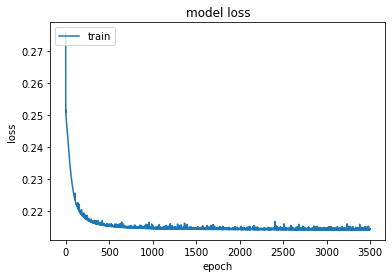

In [40]:
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(loss_arr)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [174]:
model.eval() # eval mode
out, hidden = model(X_train)

<ipython-input-149-e7d8c41a385c>:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(out)


In [175]:
for i in range(120):
    print(str(i) + "->" + str(out[i]))

0->tensor([0.9290, 0.0710], grad_fn=<SelectBackward>)
1->tensor([0.5556, 0.4444], grad_fn=<SelectBackward>)
2->tensor([0.4703, 0.5297], grad_fn=<SelectBackward>)
3->tensor([0.4587, 0.5413], grad_fn=<SelectBackward>)
4->tensor([0.4571, 0.5429], grad_fn=<SelectBackward>)
5->tensor([0.4569, 0.5431], grad_fn=<SelectBackward>)
6->tensor([0.4569, 0.5431], grad_fn=<SelectBackward>)
7->tensor([0.4569, 0.5431], grad_fn=<SelectBackward>)
8->tensor([0.4569, 0.5431], grad_fn=<SelectBackward>)
9->tensor([0.4569, 0.5431], grad_fn=<SelectBackward>)
10->tensor([0.4569, 0.5431], grad_fn=<SelectBackward>)
11->tensor([0.4569, 0.5431], grad_fn=<SelectBackward>)
12->tensor([0.4569, 0.5431], grad_fn=<SelectBackward>)
13->tensor([0.4569, 0.5431], grad_fn=<SelectBackward>)
14->tensor([0.4569, 0.5431], grad_fn=<SelectBackward>)
15->tensor([0.2942, 0.7058], grad_fn=<SelectBackward>)
16->tensor([0.4569, 0.5431], grad_fn=<SelectBackward>)
17->tensor([0.4569, 0.5431], grad_fn=<SelectBackward>)
18->tensor([0.4569, 

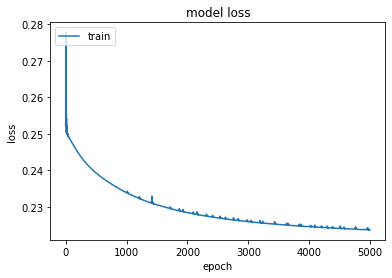

In [17]:
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(loss_arr)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
import shutil

def save_ckp(state, is_best, checkpoint_dir, best_model_dir):
    f_path = checkpoint_dir + '/' + 'checkpoint.pt'
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_dir + '/' + 'best_model.pt'
        shutil.copyfile(f_path, best_fpath)

In [ ]:
checkpoint = {
    'epoch': n_epochs + 1,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()
}
model_path = r"/home/ryo/Desktop/tcc/workspace/2-train_lstm/"
save_ckp(checkpoint, True, model_path, model_path)

## Trained with sigmoid output

In [23]:
# Training Run
model.train()

epoch_start = 5000

for epoch in range(epoch_start, epoch_start + n_epochs):
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    #input_seq.to(device)
    output, hidden = model(X_train)
    # print(output)
    loss = criterion(output, Y_train.view(-1,2).float())
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly
    
    loss_arr.append(loss.item())
    
    if epoch%10 == 0:
        acc = float((torch.sum((torch.argmax(output, axis=1) == torch.argmax(Y_train.squeeze(), axis=1)).int())/120))
        print('Epoch: {}/{}.............'.format(epoch, epoch_start + n_epochs), end=' ')
        print("Loss: {:.15f} Acc: {:.15f}".format(loss.item(), acc))

epoch_start = epoch_start + n_epochs + 1

Epoch: 5000/25000............. Loss: 0.222982302308083 Acc: 0.591666638851166
Epoch: 5010/25000............. Loss: 0.222971484065056 Acc: 0.591666638851166
Epoch: 5020/25000............. Loss: 0.222966954112053 Acc: 0.591666638851166
Epoch: 5030/25000............. Loss: 0.222961366176605 Acc: 0.591666638851166
Epoch: 5040/25000............. Loss: 0.222956269979477 Acc: 0.591666638851166
Epoch: 5050/25000............. Loss: 0.222951456904411 Acc: 0.591666638851166
Epoch: 5060/25000............. Loss: 0.222946539521217 Acc: 0.591666638851166
Epoch: 5070/25000............. Loss: 0.222941935062408 Acc: 0.591666638851166
Epoch: 5080/25000............. Loss: 0.222959235310555 Acc: 0.591666638851166
Epoch: 5090/25000............. Loss: 0.223307505249977 Acc: 0.591666638851166
Epoch: 5100/25000............. Loss: 0.222927808761597 Acc: 0.591666638851166
Epoch: 5110/25000............. Loss: 0.222968384623528 Acc: 0.600000023841858
Epoch: 5120/25000............. Loss: 0.222917661070824 Acc: 0.59

Epoch: 6060/25000............. Loss: 0.222522020339966 Acc: 0.600000023841858
Epoch: 6070/25000............. Loss: 0.222518235445023 Acc: 0.600000023841858
Epoch: 6080/25000............. Loss: 0.222514435648918 Acc: 0.600000023841858
Epoch: 6090/25000............. Loss: 0.222510620951653 Acc: 0.600000023841858
Epoch: 6100/25000............. Loss: 0.222506821155548 Acc: 0.600000023841858
Epoch: 6110/25000............. Loss: 0.222506210207939 Acc: 0.600000023841858
Epoch: 6120/25000............. Loss: 0.222766846418381 Acc: 0.600000023841858
Epoch: 6130/25000............. Loss: 0.223067685961723 Acc: 0.591666638851166
Epoch: 6140/25000............. Loss: 0.222714021801949 Acc: 0.600000023841858
Epoch: 6150/25000............. Loss: 0.222520321607590 Acc: 0.600000023841858
Epoch: 6160/25000............. Loss: 0.222500011324883 Acc: 0.591666638851166
Epoch: 6170/25000............. Loss: 0.222490772604942 Acc: 0.591666638851166
Epoch: 6180/25000............. Loss: 0.222479000687599 Acc: 0.60

Epoch: 7120/25000............. Loss: 0.222235515713692 Acc: 0.600000023841858
Epoch: 7130/25000............. Loss: 0.222168862819672 Acc: 0.600000023841858
Epoch: 7140/25000............. Loss: 0.222202494740486 Acc: 0.591666638851166
Epoch: 7150/25000............. Loss: 0.222489103674889 Acc: 0.591666638851166
Epoch: 7160/25000............. Loss: 0.222169443964958 Acc: 0.600000023841858
Epoch: 7170/25000............. Loss: 0.222185447812080 Acc: 0.600000023841858
Epoch: 7180/25000............. Loss: 0.222161069512367 Acc: 0.600000023841858
Epoch: 7190/25000............. Loss: 0.222150996327400 Acc: 0.600000023841858
Epoch: 7200/25000............. Loss: 0.222149357199669 Acc: 0.600000023841858
Epoch: 7210/25000............. Loss: 0.222145229578018 Acc: 0.600000023841858
Epoch: 7220/25000............. Loss: 0.222141876816750 Acc: 0.600000023841858
Epoch: 7230/25000............. Loss: 0.222138971090317 Acc: 0.600000023841858
Epoch: 7240/25000............. Loss: 0.222136080265045 Acc: 0.60

Epoch: 8180/25000............. Loss: 0.221890777349472 Acc: 0.600000023841858
Epoch: 8190/25000............. Loss: 0.222008615732193 Acc: 0.600000023841858
Epoch: 8200/25000............. Loss: 0.222262576222420 Acc: 0.600000023841858
Epoch: 8210/25000............. Loss: 0.222068160772324 Acc: 0.600000023841858
Epoch: 8220/25000............. Loss: 0.221882626414299 Acc: 0.600000023841858
Epoch: 8230/25000............. Loss: 0.221898943185806 Acc: 0.600000023841858
Epoch: 8240/25000............. Loss: 0.221880972385406 Acc: 0.600000023841858
Epoch: 8250/25000............. Loss: 0.221872508525848 Acc: 0.600000023841858
Epoch: 8260/25000............. Loss: 0.221870645880699 Acc: 0.600000023841858
Epoch: 8270/25000............. Loss: 0.221868142485619 Acc: 0.600000023841858
Epoch: 8280/25000............. Loss: 0.221865579485893 Acc: 0.600000023841858
Epoch: 8290/25000............. Loss: 0.221863105893135 Acc: 0.600000023841858
Epoch: 8300/25000............. Loss: 0.221860736608505 Acc: 0.60

Epoch: 9240/25000............. Loss: 0.221657305955887 Acc: 0.600000023841858
Epoch: 9250/25000............. Loss: 0.221659258008003 Acc: 0.600000023841858
Epoch: 9260/25000............. Loss: 0.221991509199142 Acc: 0.591666638851166
Epoch: 9270/25000............. Loss: 0.221845626831055 Acc: 0.600000023841858
Epoch: 9280/25000............. Loss: 0.221649646759033 Acc: 0.600000023841858
Epoch: 9290/25000............. Loss: 0.221671774983406 Acc: 0.600000023841858
Epoch: 9300/25000............. Loss: 0.221645519137383 Acc: 0.600000023841858
Epoch: 9310/25000............. Loss: 0.221646606922150 Acc: 0.600000023841858
Epoch: 9320/25000............. Loss: 0.221641510725021 Acc: 0.600000023841858
Epoch: 9330/25000............. Loss: 0.221639975905418 Acc: 0.600000023841858
Epoch: 9340/25000............. Loss: 0.221655905246735 Acc: 0.600000023841858
Epoch: 9350/25000............. Loss: 0.222022995352745 Acc: 0.600000023841858
Epoch: 9360/25000............. Loss: 0.221662938594818 Acc: 0.60

Epoch: 10290/25000............. Loss: 0.221468925476074 Acc: 0.600000023841858
Epoch: 10300/25000............. Loss: 0.221462890505791 Acc: 0.600000023841858
Epoch: 10310/25000............. Loss: 0.221462666988373 Acc: 0.600000023841858
Epoch: 10320/25000............. Loss: 0.221567213535309 Acc: 0.600000023841858
Epoch: 10330/25000............. Loss: 0.221469983458519 Acc: 0.600000023841858
Epoch: 10340/25000............. Loss: 0.221548095345497 Acc: 0.600000023841858
Epoch: 10350/25000............. Loss: 0.221459627151489 Acc: 0.600000023841858
Epoch: 10360/25000............. Loss: 0.221461370587349 Acc: 0.600000023841858
Epoch: 10370/25000............. Loss: 0.221452653408051 Acc: 0.600000023841858
Epoch: 10380/25000............. Loss: 0.221450805664062 Acc: 0.600000023841858
Epoch: 10390/25000............. Loss: 0.221447885036469 Acc: 0.600000023841858
Epoch: 10400/25000............. Loss: 0.221446350216866 Acc: 0.600000023841858
Epoch: 10410/25000............. Loss: 0.221444591879

Epoch: 11330/25000............. Loss: 0.221302226185799 Acc: 0.600000023841858
Epoch: 11340/25000............. Loss: 0.221300631761551 Acc: 0.600000023841858
Epoch: 11350/25000............. Loss: 0.221298933029175 Acc: 0.600000023841858
Epoch: 11360/25000............. Loss: 0.221297800540924 Acc: 0.600000023841858
Epoch: 11370/25000............. Loss: 0.221328720450401 Acc: 0.600000023841858
Epoch: 11380/25000............. Loss: 0.221521124243736 Acc: 0.600000023841858
Epoch: 11390/25000............. Loss: 0.221298620104790 Acc: 0.600000023841858
Epoch: 11400/25000............. Loss: 0.221330612897873 Acc: 0.600000023841858
Epoch: 11410/25000............. Loss: 0.221290335059166 Acc: 0.600000023841858
Epoch: 11420/25000............. Loss: 0.221293941140175 Acc: 0.600000023841858
Epoch: 11430/25000............. Loss: 0.221288263797760 Acc: 0.600000023841858
Epoch: 11440/25000............. Loss: 0.221319451928139 Acc: 0.600000023841858
Epoch: 11450/25000............. Loss: 0.221511691808

Epoch: 12370/25000............. Loss: 0.221160277724266 Acc: 0.600000023841858
Epoch: 12380/25000............. Loss: 0.221172511577606 Acc: 0.600000023841858
Epoch: 12390/25000............. Loss: 0.221562817692757 Acc: 0.600000023841858
Epoch: 12400/25000............. Loss: 0.221232399344444 Acc: 0.600000023841858
Epoch: 12410/25000............. Loss: 0.221165210008621 Acc: 0.600000023841858
Epoch: 12420/25000............. Loss: 0.221169099211693 Acc: 0.600000023841858
Epoch: 12430/25000............. Loss: 0.221152439713478 Acc: 0.600000023841858
Epoch: 12440/25000............. Loss: 0.221152722835541 Acc: 0.600000023841858
Epoch: 12450/25000............. Loss: 0.221150711178780 Acc: 0.600000023841858
Epoch: 12460/25000............. Loss: 0.221148774027824 Acc: 0.600000023841858
Epoch: 12470/25000............. Loss: 0.221147373318672 Acc: 0.600000023841858
Epoch: 12480/25000............. Loss: 0.221146106719971 Acc: 0.600000023841858
Epoch: 12490/25000............. Loss: 0.221145570278

Epoch: 13410/25000............. Loss: 0.221039071679115 Acc: 0.600000023841858
Epoch: 13420/25000............. Loss: 0.221035271883011 Acc: 0.600000023841858
Epoch: 13430/25000............. Loss: 0.221034571528435 Acc: 0.600000023841858
Epoch: 13440/25000............. Loss: 0.221033006906509 Acc: 0.600000023841858
Epoch: 13450/25000............. Loss: 0.221031725406647 Acc: 0.600000023841858
Epoch: 13460/25000............. Loss: 0.221030578017235 Acc: 0.600000023841858
Epoch: 13470/25000............. Loss: 0.221029445528984 Acc: 0.600000023841858
Epoch: 13480/25000............. Loss: 0.221028342843056 Acc: 0.600000023841858
Epoch: 13490/25000............. Loss: 0.221027210354805 Acc: 0.600000023841858
Epoch: 13500/25000............. Loss: 0.221026122570038 Acc: 0.600000023841858
Epoch: 13510/25000............. Loss: 0.221025541424751 Acc: 0.600000023841858
Epoch: 13520/25000............. Loss: 0.221048071980476 Acc: 0.600000023841858
Epoch: 13530/25000............. Loss: 0.221321046352

Epoch: 14450/25000............. Loss: 0.220926761627197 Acc: 0.600000023841858
Epoch: 14460/25000............. Loss: 0.220925539731979 Acc: 0.600000023841858
Epoch: 14470/25000............. Loss: 0.220924586057663 Acc: 0.600000023841858
Epoch: 14480/25000............. Loss: 0.220923602581024 Acc: 0.600000023841858
Epoch: 14490/25000............. Loss: 0.220922559499741 Acc: 0.600000023841858
Epoch: 14500/25000............. Loss: 0.220921576023102 Acc: 0.600000023841858
Epoch: 14510/25000............. Loss: 0.220920547842979 Acc: 0.600000023841858
Epoch: 14520/25000............. Loss: 0.220919564366341 Acc: 0.600000023841858
Epoch: 14530/25000............. Loss: 0.220918551087379 Acc: 0.600000023841858
Epoch: 14540/25000............. Loss: 0.220917686820030 Acc: 0.600000023841858
Epoch: 14550/25000............. Loss: 0.220921814441681 Acc: 0.600000023841858
Epoch: 14560/25000............. Loss: 0.221194222569466 Acc: 0.600000023841858
Epoch: 14570/25000............. Loss: 0.221054852008

Epoch: 15490/25000............. Loss: 0.220828667283058 Acc: 0.600000023841858
Epoch: 15500/25000............. Loss: 0.220827713608742 Acc: 0.600000023841858
Epoch: 15510/25000............. Loss: 0.220826834440231 Acc: 0.600000023841858
Epoch: 15520/25000............. Loss: 0.220825910568237 Acc: 0.600000023841858
Epoch: 15530/25000............. Loss: 0.220825046300888 Acc: 0.600000023841858
Epoch: 15540/25000............. Loss: 0.220827534794807 Acc: 0.600000023841858
Epoch: 15550/25000............. Loss: 0.221093758940697 Acc: 0.600000023841858
Epoch: 15560/25000............. Loss: 0.220992505550385 Acc: 0.600000023841858
Epoch: 15570/25000............. Loss: 0.220836207270622 Acc: 0.600000023841858
Epoch: 15580/25000............. Loss: 0.220863088965416 Acc: 0.600000023841858
Epoch: 15590/25000............. Loss: 0.221146613359451 Acc: 0.600000023841858
Epoch: 15600/25000............. Loss: 0.220845520496368 Acc: 0.600000023841858
Epoch: 15610/25000............. Loss: 0.220837593078

Epoch: 16530/25000............. Loss: 0.221049621701241 Acc: 0.600000023841858
Epoch: 16540/25000............. Loss: 0.220917612314224 Acc: 0.600000023841858
Epoch: 16550/25000............. Loss: 0.220761284232140 Acc: 0.600000023841858
Epoch: 16560/25000............. Loss: 0.220766320824623 Acc: 0.600000023841858
Epoch: 16570/25000............. Loss: 0.220738559961319 Acc: 0.600000023841858
Epoch: 16580/25000............. Loss: 0.220740213990211 Acc: 0.600000023841858
Epoch: 16590/25000............. Loss: 0.220735818147659 Acc: 0.600000023841858
Epoch: 16600/25000............. Loss: 0.220735341310501 Acc: 0.600000023841858
Epoch: 16610/25000............. Loss: 0.220734298229218 Acc: 0.600000023841858
Epoch: 16620/25000............. Loss: 0.220733359456062 Acc: 0.600000023841858
Epoch: 16630/25000............. Loss: 0.220732510089874 Acc: 0.600000023841858
Epoch: 16640/25000............. Loss: 0.220731735229492 Acc: 0.600000023841858
Epoch: 16650/25000............. Loss: 0.220730945467

Epoch: 17570/25000............. Loss: 0.220661178231239 Acc: 0.600000023841858
Epoch: 17580/25000............. Loss: 0.220660388469696 Acc: 0.600000023841858
Epoch: 17590/25000............. Loss: 0.220659643411636 Acc: 0.600000023841858
Epoch: 17600/25000............. Loss: 0.220658913254738 Acc: 0.600000023841858
Epoch: 17610/25000............. Loss: 0.220658197999001 Acc: 0.600000023841858
Epoch: 17620/25000............. Loss: 0.220657601952553 Acc: 0.600000023841858
Epoch: 17630/25000............. Loss: 0.220660701394081 Acc: 0.600000023841858
Epoch: 17640/25000............. Loss: 0.220839530229568 Acc: 0.600000023841858
Epoch: 17650/25000............. Loss: 0.220702111721039 Acc: 0.600000023841858
Epoch: 17660/25000............. Loss: 0.220710888504982 Acc: 0.600000023841858
Epoch: 17670/25000............. Loss: 0.220661938190460 Acc: 0.600000023841858
Epoch: 17680/25000............. Loss: 0.220654800534248 Acc: 0.600000023841858
Epoch: 17690/25000............. Loss: 0.220808729529

Epoch: 18610/25000............. Loss: 0.220594927668571 Acc: 0.600000023841858
Epoch: 18620/25000............. Loss: 0.220600560307503 Acc: 0.600000023841858
Epoch: 18630/25000............. Loss: 0.220870092511177 Acc: 0.600000023841858
Epoch: 18640/25000............. Loss: 0.220722302794456 Acc: 0.600000023841858
Epoch: 18650/25000............. Loss: 0.220613807439804 Acc: 0.600000023841858
Epoch: 18660/25000............. Loss: 0.220588058233261 Acc: 0.600000023841858
Epoch: 18670/25000............. Loss: 0.220591679215431 Acc: 0.600000023841858
Epoch: 18680/25000............. Loss: 0.220585390925407 Acc: 0.600000023841858
Epoch: 18690/25000............. Loss: 0.220583349466324 Acc: 0.600000023841858
Epoch: 18700/25000............. Loss: 0.220582678914070 Acc: 0.600000023841858
Epoch: 18710/25000............. Loss: 0.220581978559494 Acc: 0.600000023841858
Epoch: 18720/25000............. Loss: 0.220581352710724 Acc: 0.600000023841858
Epoch: 18730/25000............. Loss: 0.220580801367

Epoch: 19650/25000............. Loss: 0.220555916428566 Acc: 0.600000023841858
Epoch: 19660/25000............. Loss: 0.220745787024498 Acc: 0.600000023841858
Epoch: 19670/25000............. Loss: 0.220521628856659 Acc: 0.600000023841858
Epoch: 19680/25000............. Loss: 0.220551386475563 Acc: 0.600000023841858
Epoch: 19690/25000............. Loss: 0.220525518059731 Acc: 0.600000023841858
Epoch: 19700/25000............. Loss: 0.220519915223122 Acc: 0.600000023841858
Epoch: 19710/25000............. Loss: 0.220520272850990 Acc: 0.600000023841858
Epoch: 19720/25000............. Loss: 0.220518693327904 Acc: 0.600000023841858
Epoch: 19730/25000............. Loss: 0.220517739653587 Acc: 0.600000023841858
Epoch: 19740/25000............. Loss: 0.220526158809662 Acc: 0.600000023841858
Epoch: 19750/25000............. Loss: 0.220992624759674 Acc: 0.600000023841858
Epoch: 19760/25000............. Loss: 0.220597758889198 Acc: 0.600000023841858
Epoch: 19770/25000............. Loss: 0.220550358295

Epoch: 20690/25000............. Loss: 0.220513358712196 Acc: 0.600000023841858
Epoch: 20700/25000............. Loss: 0.220461219549179 Acc: 0.600000023841858
Epoch: 20710/25000............. Loss: 0.220467850565910 Acc: 0.600000023841858
Epoch: 20720/25000............. Loss: 0.220460191369057 Acc: 0.600000023841858
Epoch: 20730/25000............. Loss: 0.220460548996925 Acc: 0.600000023841858
Epoch: 20740/25000............. Loss: 0.220459043979645 Acc: 0.600000023841858
Epoch: 20750/25000............. Loss: 0.220458477735519 Acc: 0.600000023841858
Epoch: 20760/25000............. Loss: 0.220457926392555 Acc: 0.600000023841858
Epoch: 20770/25000............. Loss: 0.220457330346107 Acc: 0.600000023841858
Epoch: 20780/25000............. Loss: 0.220456779003143 Acc: 0.600000023841858
Epoch: 20790/25000............. Loss: 0.220456317067146 Acc: 0.600000023841858
Epoch: 20800/25000............. Loss: 0.220460399985313 Acc: 0.600000023841858
Epoch: 20810/25000............. Loss: 0.220797479152

Epoch: 21730/25000............. Loss: 0.220410004258156 Acc: 0.600000023841858
Epoch: 21740/25000............. Loss: 0.220469400286674 Acc: 0.600000023841858
Epoch: 21750/25000............. Loss: 0.220416307449341 Acc: 0.600000023841858
Epoch: 21760/25000............. Loss: 0.220417410135269 Acc: 0.600000023841858
Epoch: 21770/25000............. Loss: 0.220803737640381 Acc: 0.600000023841858
Epoch: 21780/25000............. Loss: 0.220539227128029 Acc: 0.600000023841858
Epoch: 21790/25000............. Loss: 0.220402851700783 Acc: 0.600000023841858
Epoch: 21800/25000............. Loss: 0.220420524477959 Acc: 0.600000023841858
Epoch: 21810/25000............. Loss: 0.220402926206589 Acc: 0.600000023841858
Epoch: 21820/25000............. Loss: 0.220402002334595 Acc: 0.600000023841858
Epoch: 21830/25000............. Loss: 0.220401540398598 Acc: 0.600000023841858
Epoch: 21840/25000............. Loss: 0.220400348305702 Acc: 0.600000023841858
Epoch: 21850/25000............. Loss: 0.220399633049

Epoch: 22770/25000............. Loss: 0.220354065299034 Acc: 0.600000023841858
Epoch: 22780/25000............. Loss: 0.220353513956070 Acc: 0.600000023841858
Epoch: 22790/25000............. Loss: 0.220353037118912 Acc: 0.600000023841858
Epoch: 22800/25000............. Loss: 0.220352515578270 Acc: 0.600000023841858
Epoch: 22810/25000............. Loss: 0.220352038741112 Acc: 0.600000023841858
Epoch: 22820/25000............. Loss: 0.220351547002792 Acc: 0.600000023841858
Epoch: 22830/25000............. Loss: 0.220351070165634 Acc: 0.600000023841858
Epoch: 22840/25000............. Loss: 0.220350593328476 Acc: 0.600000023841858
Epoch: 22850/25000............. Loss: 0.220350116491318 Acc: 0.600000023841858
Epoch: 22860/25000............. Loss: 0.220349818468094 Acc: 0.600000023841858
Epoch: 22870/25000............. Loss: 0.220360964536667 Acc: 0.600000023841858
Epoch: 22880/25000............. Loss: 0.220927566289902 Acc: 0.600000023841858
Epoch: 22890/25000............. Loss: 0.220424622297

Epoch: 23810/25000............. Loss: 0.220343157649040 Acc: 0.600000023841858
Epoch: 23820/25000............. Loss: 0.220504984259605 Acc: 0.600000023841858
Epoch: 23830/25000............. Loss: 0.220309630036354 Acc: 0.600000023841858
Epoch: 23840/25000............. Loss: 0.220342412590981 Acc: 0.600000023841858
Epoch: 23850/25000............. Loss: 0.220304206013680 Acc: 0.600000023841858
Epoch: 23860/25000............. Loss: 0.220307961106300 Acc: 0.600000023841858
Epoch: 23870/25000............. Loss: 0.220304220914841 Acc: 0.600000023841858
Epoch: 23880/25000............. Loss: 0.220302715897560 Acc: 0.600000023841858
Epoch: 23890/25000............. Loss: 0.220302358269691 Acc: 0.600000023841858
Epoch: 23900/25000............. Loss: 0.220301911234856 Acc: 0.600000023841858
Epoch: 23910/25000............. Loss: 0.220301464200020 Acc: 0.600000023841858
Epoch: 23920/25000............. Loss: 0.220302134752274 Acc: 0.600000023841858
Epoch: 23930/25000............. Loss: 0.220373004674

Epoch: 24850/25000............. Loss: 0.220366865396500 Acc: 0.600000023841858
Epoch: 24860/25000............. Loss: 0.220261007547379 Acc: 0.600000023841858
Epoch: 24870/25000............. Loss: 0.220319420099258 Acc: 0.600000023841858
Epoch: 24880/25000............. Loss: 0.220273464918137 Acc: 0.600000023841858
Epoch: 24890/25000............. Loss: 0.220260620117188 Acc: 0.600000023841858
Epoch: 24900/25000............. Loss: 0.220262423157692 Acc: 0.600000023841858
Epoch: 24910/25000............. Loss: 0.220259532332420 Acc: 0.600000023841858
Epoch: 24920/25000............. Loss: 0.220258250832558 Acc: 0.600000023841858
Epoch: 24930/25000............. Loss: 0.220263570547104 Acc: 0.600000023841858
Epoch: 24940/25000............. Loss: 0.220920100808144 Acc: 0.600000023841858
Epoch: 24950/25000............. Loss: 0.220266401767731 Acc: 0.600000023841858
Epoch: 24960/25000............. Loss: 0.220303729176521 Acc: 0.600000023841858
Epoch: 24970/25000............. Loss: 0.220283314585

In [24]:
model.eval() # eval mode
out, hidden = model(X_train)

In [25]:
for i in range(120):
    print(str(i) + "->" + str(out[i]))

0->tensor([9.9993e-01, 7.2820e-05], grad_fn=<SelectBackward>)
1->tensor([1.0000e+00, 7.7964e-07], grad_fn=<SelectBackward>)
2->tensor([1.0000e+00, 6.1047e-08], grad_fn=<SelectBackward>)
3->tensor([9.9990e-01, 9.9200e-05], grad_fn=<SelectBackward>)
4->tensor([0.8637, 0.1348], grad_fn=<SelectBackward>)
5->tensor([0.5360, 0.4628], grad_fn=<SelectBackward>)
6->tensor([0.4740, 0.5251], grad_fn=<SelectBackward>)
7->tensor([0.4655, 0.5336], grad_fn=<SelectBackward>)
8->tensor([0.4644, 0.5347], grad_fn=<SelectBackward>)
9->tensor([0.4643, 0.5349], grad_fn=<SelectBackward>)
10->tensor([0.6674, 0.3318], grad_fn=<SelectBackward>)
11->tensor([0.6674, 0.3318], grad_fn=<SelectBackward>)
12->tensor([0.4642, 0.5349], grad_fn=<SelectBackward>)
13->tensor([0.4642, 0.5349], grad_fn=<SelectBackward>)
14->tensor([0.4642, 0.5349], grad_fn=<SelectBackward>)
15->tensor([0.9542, 0.0453], grad_fn=<SelectBackward>)
16->tensor([0.4642, 0.5349], grad_fn=<SelectBackward>)
17->tensor([0.9503, 0.0493], grad_fn=<Selec

## Graph before loss array being erased

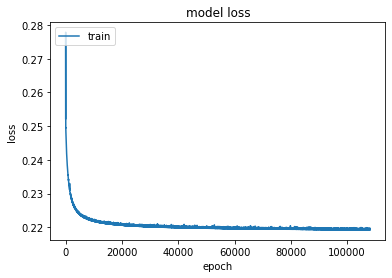

In [30]:
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(loss_arr)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [27]:
torch.save(model.state_dict(), r"/home/ryo/Desktop/tcc/workspace/2-train_lstm/pytorch_lstm_model")

## Load trained model

In [162]:
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']

In [165]:
model = Model(input_size=20400, output_size=2, hidden_dim=200, n_layers=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
ckp_path = "/home/ryo/Desktop/tcc/workspace/2-train_lstm/checkpoint.pt"
model, optimizer, start_epoch = load_ckp(ckp_path, model, optimizer)
model.eval()

Model(
  (lstm): LSTM(20400, 200, batch_first=True)
  (sigmoid1): Sigmoid()
  (fc): Linear(in_features=200, out_features=2, bias=True)
  (softmax): Softmax(dim=None)
)

In [166]:
"""model = Model(input_size=20400, output_size=2, hidden_dim=200, n_layers=1)
model.load_state_dict(torch.load(r"/home/ryo/Desktop/tcc/workspace/2-train_lstm/pytorch_lstm_model"))
model.eval()"""

'model = Model(input_size=20400, output_size=2, hidden_dim=200, n_layers=1)\nmodel.load_state_dict(torch.load(r"/home/ryo/Desktop/tcc/workspace/2-train_lstm/pytorch_lstm_model"))\nmodel.eval()'

In [167]:
print(model.lstm.weight_ih_l0.shape)
print(model.lstm.weight_hh_l0.shape)
print(model.lstm.bias_ih_l0.shape)
print(model.lstm.bias_hh_l0.shape)
print(model.fc.weight.shape)
print(model.fc.bias.shape)

torch.Size([800, 20400])
torch.Size([800, 200])
torch.Size([800])
torch.Size([800])
torch.Size([2, 200])
torch.Size([2])


## Output model predicted data

In [168]:
lstmcell = nn.LSTMCell(20400, 200)
sig1 = nn.Sigmoid()
linear = nn.Linear(200, 2)
softmax = nn.Softmax()

In [169]:
lstmcell.weight_ih = model.lstm.weight_ih_l0
lstmcell.weight_hh = model.lstm.weight_hh_l0
lstmcell.bias_hh = model.lstm.bias_hh_l0
lstmcell.bias_ih = model.lstm.bias_ih_l0

In [170]:
linear.weight = model.fc.weight
linear.bias = model.fc.bias

In [171]:
hx = torch.zeros(1, 200)
cx = torch.zeros(1, 200)

In [172]:
output = []
for i in range(120):
    step_input = X_train[0][i]
    step_input = step_input.reshape(1, -1)
    hx, cx = lstmcell(step_input, (hx, cx))
    out = sig1(hx)
    out = linear(out)
    out = softmax(out)
    output.append(out)

<ipython-input-172-1e7e3824cb14>:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = softmax(out)


In [173]:
output

[tensor([[0.9290, 0.0710]], grad_fn=<SoftmaxBackward>),
 tensor([[0.5556, 0.4444]], grad_fn=<SoftmaxBackward>),
 tensor([[0.4703, 0.5297]], grad_fn=<SoftmaxBackward>),
 tensor([[0.4587, 0.5413]], grad_fn=<SoftmaxBackward>),
 tensor([[0.4571, 0.5429]], grad_fn=<SoftmaxBackward>),
 tensor([[0.4569, 0.5431]], grad_fn=<SoftmaxBackward>),
 tensor([[0.4569, 0.5431]], grad_fn=<SoftmaxBackward>),
 tensor([[0.4569, 0.5431]], grad_fn=<SoftmaxBackward>),
 tensor([[0.4569, 0.5431]], grad_fn=<SoftmaxBackward>),
 tensor([[0.4569, 0.5431]], grad_fn=<SoftmaxBackward>),
 tensor([[0.4569, 0.5431]], grad_fn=<SoftmaxBackward>),
 tensor([[0.4569, 0.5431]], grad_fn=<SoftmaxBackward>),
 tensor([[0.4569, 0.5431]], grad_fn=<SoftmaxBackward>),
 tensor([[0.4569, 0.5431]], grad_fn=<SoftmaxBackward>),
 tensor([[0.4569, 0.5431]], grad_fn=<SoftmaxBackward>),
 tensor([[0.2942, 0.7058]], grad_fn=<SoftmaxBackward>),
 tensor([[0.4569, 0.5431]], grad_fn=<SoftmaxBackward>),
 tensor([[0.4569, 0.5431]], grad_fn=<SoftmaxBack